!pip install pydot graphviz


In [1]:
#!pip install torchsummary



In [2]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import tensorflow as tf
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

from utils.helper import fn_plot_torch_hist

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Global variables
inpDir = '../input' # Input Stored here
outDir = '../ouput' # output Here
modelDir = './models'# to save Models
subDir = 'fifa_2019' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
#rng = np.random.default_rng(seed = RANDOM_STATE)
#N_SAMPLE = 1000
TEST_SIZE = 0.2
ALPHA = 0.001 # learning rate
NOISE = 0.2 # Error
EPOCHS = 101
BATCH_SIZE = 256
LR_FACTOR=0.1
LR_PATIENCE=10

In [5]:
#set the plotting parameters
params = {
    'legend.fontsize': 'medium',
    'figure.figsize':(15,4),
    'axes.labelsize':'medium',
    'axes.titlesize':'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize':'medium',
    #'text.usetex':True,
}
plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


In [6]:
# data_df = pd.read_csv(os.path.join(inpDir,'fifa_2019.csv'))

In [7]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
valid_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
valid_df = pd.read_csv(valid_filename, header = 0)


train_df.shape, valid_df.shape

((60000, 785), (10000, 785))

In [8]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# for col in train_df.columns:
#     unq = train_df[col].unique()
#     print(f'{col}, #:{len(unq)}, Values:{unq}')

In [10]:
train_df.columns[-10:]

Index(['pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object')

In [11]:
# data_df.dropna(subset= ('Position'), inplace = True)
train_df.isna().sum().sum()

0

In [12]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [13]:
# num_cols = data_df.select_dtypes(exclude='object')

In [14]:
# num_cols.info()

In [15]:
# rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 
#             'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 
#             'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 
#             'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']


In [16]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [60]:
class_names = {
    0: 'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8:'Bag', 
    9: 'Ankle boot'
}

In [18]:
X = train_df.drop('label',axis=1)
y = train_df['label'].to_numpy()

## Split Data in test train

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48000, 784), (12000, 784), (48000,), (12000,))

In [20]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 numpy.ndarray)

In [21]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
X_train.shape

(48000, 784)

In [23]:
'''Define custom dataset'''
class MnistDataset(Dataset):
    def __init__(self, X, y):
        super(MnistDataset, self).__init__()
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)
        
    def __len__(self): # length of the data = no. of rows 
        return(len(self.X))

    def __getitem__(self, idx): # give me index of X , y
        return self.X[idx], self.y[idx]
    

In [24]:
train_dataset = MnistDataset(X_train, y_train)

In [25]:
train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = BATCH_SIZE,
    shuffle = True
)

In [26]:
train_loader

In [27]:
X_batch, y_batch = next(iter(train_loader))

In [28]:
X_batch.shape, y_batch.shape

(torch.Size([256, 784]), torch.Size([256]))

In [29]:
test_dataset = MnistDataset(X_test, y_test)

In [ ]:
test_loader = DataLoader(dataset = test_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True
                         )
X_batch, y_batch = next(iter(test_loader))
X_batch.shape, y_batch.shape

(torch.Size([256, 784]), torch.Size([256]))

## comments are alternate ways to do 

* Is environment Ok

In [31]:
# torch.cuda.is_available()

In [32]:
# import torch.version
# torch.version.cuda

In [33]:
# torch.cuda.get_device_name(torch.cuda.current_device())

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [35]:
X_train.shape[1]

784

In [ ]:
input_dim = X_train.shape[1]

class Model(nn.Module):
    
    def __init__(self, input_dim):
        super(Model, self).__init__()

        # Set 1
        dor1 = 0.3
        self.layer1 = nn.Linear(input_dim, 392)
        self.actv1 = nn.ReLU()
        self.do1 = nn.Dropout(dor1)
        self.bn1 = nn.BatchNorm1d(392) # Size same as from layer1
        
        # Set 2
        dor2 = 0.3
        self.layer2 = nn.Linear(392, 196)
        self.actv2 = nn.ReLU()
        self.do2 = nn.Dropout(dor2)
        self.bn2 = nn.BatchNorm1d(196) # Size same as o/p from layer2
        
        # Set 3
        dor3 = 0.5
        self.layer3 = nn.Linear(196, 98)
        self.actv3 = nn.ReLU()
        self.do3 = nn.Dropout(dor3)
        self.bn3 = nn.BatchNorm1d(98) # Size same as o/p from layer3
        
        # Set 4
        self.layer4 = nn.Linear(98, 10)
 

    def forward(self, x):
        # Set 1
        x = self.layer1(x)
        x = self.bn1(x)     # Batch Norm
        x = self.actv1(x)
        x = self.do1(x)

        # Set 2
        x = self.layer2(x)
        x = self.bn2(x)     # Batch Norm
        x = self.actv2(x)
        x = self.do2(x)

        # Set 3
        x = self.layer3(x)
        x = self.bn3(x)     # Batch Norm
        x = self.actv3(x)
        x = self.do3(x)

        # Set 4
        x = self.layer4(x)
        return x


In [63]:
model = Model(input_dim).to(device=device)
print(model)

# model = nn.Sequential(nn.Linear(input_dim, 18),
#                      nn.ReLU(),
#                      nn.Linear(18,4)
#                      ).to(device=device)


Model(
  (layer1): Linear(in_features=784, out_features=392, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=392, out_features=196, bias=True)
  (actv2): ReLU()
  (do2): Dropout(p=0.3, inplace=False)
  (bn2): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=196, out_features=98, bias=True)
  (actv3): ReLU()
  (do3): Dropout(p=0.5, inplace=False)
  (bn3): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=98, out_features=10, bias=True)
)


In [64]:
# summary(model, (18,33))
summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 392]         307,720
       BatchNorm1d-2                  [-1, 392]             784
              ReLU-3                  [-1, 392]               0
           Dropout-4                  [-1, 392]               0
            Linear-5                  [-1, 196]          77,028
       BatchNorm1d-6                  [-1, 196]             392
              ReLU-7                  [-1, 196]               0
           Dropout-8                  [-1, 196]               0
            Linear-9                   [-1, 98]          19,306
      BatchNorm1d-10                   [-1, 98]             196
             ReLU-11                   [-1, 98]               0
          Dropout-12                   [-1, 98]               0
           Linear-13                   [-1, 10]             990
Total params: 406,416
Trainable params:

In [65]:
for param in list(model.parameters()):
    print(param.shape)

# Input
#Bias


torch.Size([392, 784])
torch.Size([392])
torch.Size([392])
torch.Size([392])
torch.Size([196, 392])
torch.Size([196])
torch.Size([196])
torch.Size([196])
torch.Size([98, 196])
torch.Size([98])
torch.Size([98])
torch.Size([98])
torch.Size([10, 98])
torch.Size([10])


In [66]:
# train_X = torch.tensor(X_train, dtype=torch.float32, device=device)
# train_y = torch.tensor(y_train, dtype=torch.int64, device=device)

# test_X = torch.tensor(X_test, dtype=torch.float32, device=device)
# test_y = torch.tensor(y_test, dtype=torch.int64, device=device)

In [67]:
#torch.optim.RMSprop(model.)

In [ ]:

#Loss function
#Compilation and # Fit()
loss_fn = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# If modell not improving after no. of epochs reduce LR with LR_FACTOR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    min_lr=1e-5
)
# always need to write 
# some lists to collect progress
loss = []
tloss = []
n_epoch = []
acc = []
tacc=[]

# loop for definedd epochs
for epoch in range(EPOCHS):
    model.train() # set model in training mode 
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0
   
    for batch_idx, (train_X, train_y) in enumerate(train_loader):
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        predict_proba = model(train_X) # make predict
        batch_loss = loss_fn(predict_proba, train_y) # calculate loss
        epoch_loss += (batch_loss - epoch_loss) / (batch_idx+1) # calculate running mean -> batch loss for each batch -> then calculate avg loss for epoch
        #curr_loss = loss_fn(predict_proba, train_y)
        # Backpropagation
        optimizer.zero_grad() # Gradient set to Zero
        batch_loss.backward() # calculate loss in backpropagation
        optimizer.step() # move with the steps given by optimizer
        y_pred = predict_proba.argmax(dim=1).cpu().numpy()
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
        epoch_acc += (batch_acc - epoch_acc)/(batch_idx+1) #accuracy for each batch -> then calculate avg accuracy for epoch
        
    loss.append(epoch_loss.data.item())
    acc.append(epoch_acc)

    model.eval()

    for batch_idx, (test_X, test_y) in enumerate(test_loader):
        test_X, test_y = test_X.to(device), test_y.to(device)
        test_proba = model(test_X)
        batch_loss = loss_fn(test_proba, test_y)
        tepoch_loss += (batch_loss - tepoch_loss)/ (batch_idx + 1)

        y_pred =test_proba.argmax(dim=1).cpu().numpy()
        batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
        tepoch_acc += (batch_acc - tepoch_acc)/(batch_idx+1) #accuracy for each batch -> then calculate avg accuracy for epoch
    
    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.data.item())
    n_epoch.append(epoch)
    # loss.append(curr_loss.data.item())
    # y_pred = torch.argmax(predict_proba, dim=1).cpu().numpy()
    # curr_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
    # acc.append(curr_acc)

    # model.eval()# set your model in eval mode
    # test_proba = model(test_X) # make prediction
    # test_loss = loss_fn(test_proba, test_y) # calculate loss
    # tloss.append(test_loss.data.item()) # append for plotting
    
    # y_pred = torch.argmax(test_proba, dim=1).cpu().numpy()
    # test_acc = accuracy_score(test_y.cpu().numpy(),y_pred)
    # tacc.append(test_acc)
    # n_epoch.append(epoch)

    #LR Reduction step
    scheduler.step(tepoch_loss)
    if epoch % 10 == 0:
        print(f'Epoch:{epoch:>5d} | Loss: {epoch_loss:0.5f}/{tepoch_loss:0.5f}| Accuracy: {epoch_acc:0.5f}/{tepoch_acc:0.5f}')
        print(f'Acc: {epoch_acc: .5f}/{tepoch_acc: .5f}')
        print(f'LR: {scheduler.get_last_lr()[0]: .5f}')
    

Epoch:    0 | Loss: 0.72022/0.42298| Accuracy: 0.77618/0.84737
Acc:  0.77618/ 0.84737
LR:  0.00100
Epoch:   10 | Loss: 0.28468/0.30032| Accuracy: 0.89973/0.89130
Acc:  0.89973/ 0.89130
LR:  0.00100
Epoch:   20 | Loss: 0.21332/0.30882| Accuracy: 0.92339/0.89312
Acc:  0.92339/ 0.89312
LR:  0.00100
Epoch:   30 | Loss: 0.14746/0.30546| Accuracy: 0.94779/0.90447
Acc:  0.94779/ 0.90447
LR:  0.00010
Epoch:   40 | Loss: 0.13255/0.31208| Accuracy: 0.95261/0.90395
Acc:  0.95261/ 0.90395
LR:  0.00001
Epoch:   50 | Loss: 0.12809/0.31425| Accuracy: 0.95508/0.90342
Acc:  0.95508/ 0.90342
LR:  0.00001
Epoch:   60 | Loss: 0.12660/0.31530| Accuracy: 0.95489/0.90377
Acc:  0.95489/ 0.90377
LR:  0.00001
Epoch:   70 | Loss: 0.12449/0.31881| Accuracy: 0.95566/0.90364
Acc:  0.95566/ 0.90364
LR:  0.00001
Epoch:   80 | Loss: 0.12666/0.31851| Accuracy: 0.95460/0.90445
Acc:  0.95460/ 0.90445
LR:  0.00001
Epoch:   90 | Loss: 0.12145/0.32109| Accuracy: 0.95776/0.90449
Acc:  0.95776/ 0.90449
LR:  0.00001
Epoch:  10

In [69]:
loss_df = pd.DataFrame({
    'epoch':n_epoch ,
    'loss':loss,
    'test_loss':tloss,
    'acc':acc,
    'test_acc':tacc
})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.720223,0.422978,0.776180,0.847371
1,1,0.456271,0.380724,0.846867,0.861809
2,2,0.403409,0.350282,0.861806,0.870203
3,3,0.380870,0.334362,0.867312,0.880094
4,4,0.354130,0.330717,0.875353,0.878206


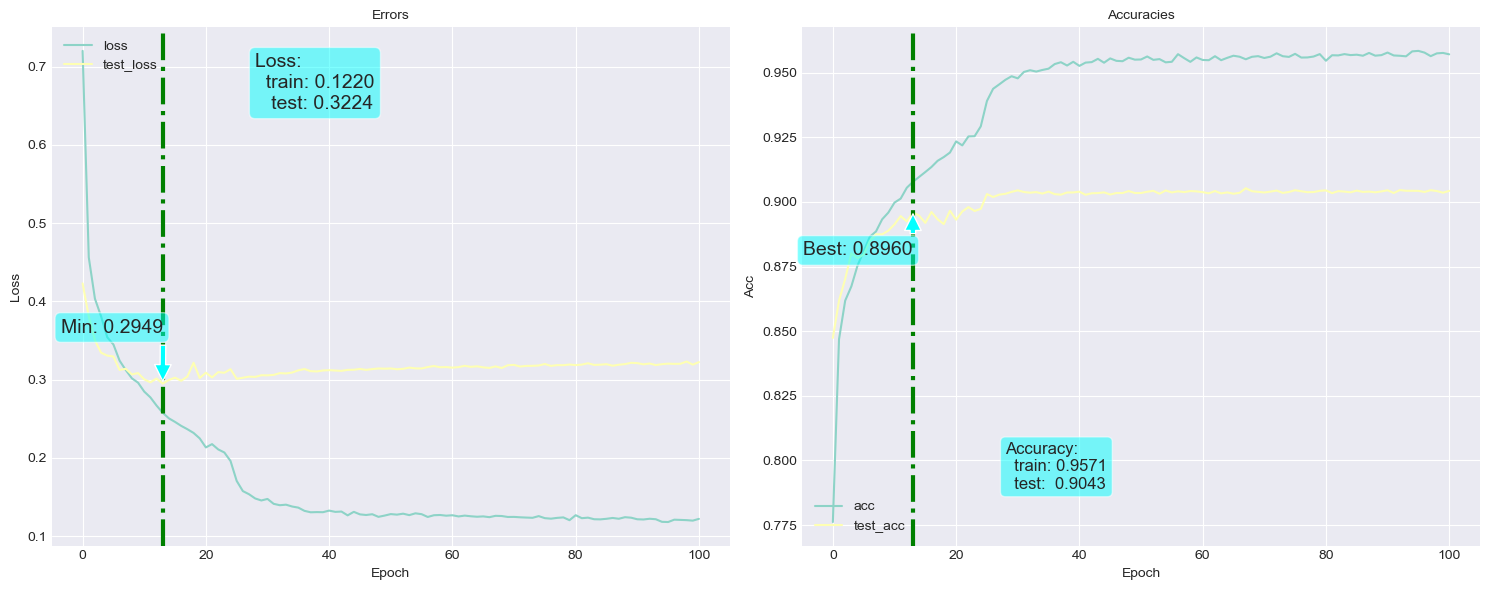

In [70]:
fn_plot_torch_hist(hist_df=loss_df)

In [71]:
outputs = model(train_X)
outputs.shape

torch.Size([128, 10])

In [72]:
y_pred = torch.argmax(outputs, dim=1).cpu().numpy() #outputs.cpu().detach().numpy()
y_pred

array([9, 4, 1, 4, 8, 0, 9, 8, 4, 2, 2, 5, 9, 1, 6, 3, 1, 5, 4, 6, 8, 8,
       2, 8, 4, 9, 0, 0, 0, 7, 0, 7, 6, 6, 3, 9, 4, 2, 0, 5, 0, 5, 2, 3,
       6, 8, 7, 1, 7, 9, 3, 0, 9, 1, 0, 3, 6, 7, 6, 0, 1, 2, 8, 5, 6, 9,
       6, 9, 9, 5, 2, 5, 4, 5, 1, 9, 6, 1, 6, 5, 6, 7, 6, 8, 6, 7, 9, 9,
       2, 9, 6, 3, 3, 4, 3, 4, 0, 2, 7, 5, 8, 8, 3, 9, 0, 4, 8, 8, 1, 5,
       3, 9, 5, 5, 3, 8, 9, 1, 7, 2, 4, 7, 3, 3, 4, 1, 2, 3], dtype=int64)

In [73]:
print(classification_report(train_y.cpu().numpy(), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        11
           3       0.93      0.93      0.93        14
           4       0.83      1.00      0.91        10
           5       1.00      1.00      1.00        13
           6       1.00      0.88      0.94        17
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        17

    accuracy                           0.98       128
   macro avg       0.98      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128



In [74]:
y_true = train_y.cpu().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        11
           3       0.93      0.93      0.93        14
           4       0.83      1.00      0.91        10
           5       1.00      1.00      1.00        13
           6       1.00      0.88      0.94        17
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        17

    accuracy                           0.98       128
   macro avg       0.98      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128



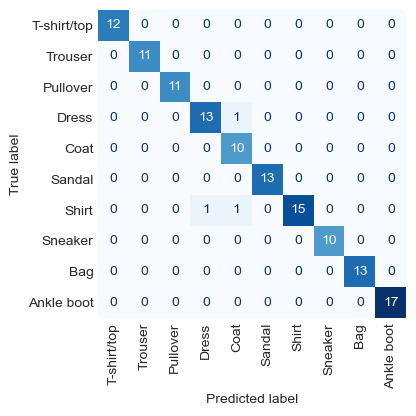

In [75]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names.values())

disp.plot(cmap= 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)

Best Hyperparameters:
batch_size: 16
dropout_rates: (0.2, 0.3, 0.4)
hidden_layers: (512, 256, 128)
learning_rate: 0.001
Best Accuracy: 0.9096666666666666

Final Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1200
           1       0.99      0.99      0.99      1200
           2       0.84      0.84      0.84      1200
           3       0.92      0.89      0.90      1200
           4       0.85      0.83      0.84      1200
           5       0.99      0.96      0.98      1200
           6       0.74      0.75      0.75      1200
           7       0.94      0.97      0.95      1200
           8       0.97      0.98      0.97      1200
           9       0.97      0.95      0.96      1200

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



<Figure size 1000x800 with 0 Axes>

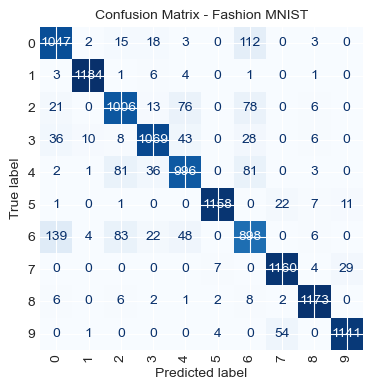

In [ ]:
import sys
sys.path.append('../')
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid


# Set random seed for reproducibility
RANDOM_STATE = 42

# Hyperparameters to tune
hyperparameter_grid = {
    'learning_rate': [
        0.001, 
        0.0005, 
    ],
    'batch_size': [
        16,
        32 
    ],
    'dropout_rates': [
        (0.2, 0.3, 0.4),
        (0.3, 0.4, 0.5),
        (0.1, 0.2, 0.3)
    ],
    'hidden_layers': [
        (392, 196, 98),
        (512, 256, 128),
        (256, 128, 64)
    ]
}

# Load and preprocess data
train_filename = os.path.join('../input', 'fashion_mnist', 'fashion-mnist_train.csv')
valid_filename = os.path.join('../input', 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header=0)
valid_df = pd.read_csv(valid_filename, header=0)

X = train_df.drop('label', axis=1)
y = train_df['label'].to_numpy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# Scale the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

class MnistDataset(Dataset):
    def __init__(self, X, y):
        super(MnistDataset, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ImprovedModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rates):
        super(ImprovedModel, self).__init__()
        
        self.layers = nn.ModuleList()
        prev_layer = input_dim
        
        for i, (hidden_size, dropout_rate) in enumerate(zip(hidden_layers, dropout_rates)):
            # Linear layer
            layer = nn.Linear(prev_layer, hidden_size)
            self.layers.append(layer)
            
            # Batch Normalization
            self.layers.append(nn.BatchNorm1d(hidden_size))
            
            # ReLU Activation
            self.layers.append(nn.ReLU())
            
            # Dropout
            self.layers.append(nn.Dropout(dropout_rate))
            
            prev_layer = hidden_size
        
        # Final classification layer
        self.final_layer = nn.Linear(hidden_layers[-1], 10)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.final_layer(x)
        return x

def train_and_evaluate(params):
    
    # Unpack hyperparameters
    lr = params['learning_rate']
    batch_size = params['batch_size']
    hidden_layers = params['hidden_layers']
    dropout_rates = params['dropout_rates']
    
    # Prepare DataLoaders
    train_dataset = MnistDataset(X_train, y_train)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = MnistDataset(X_test, y_test)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Initialize model
    model = ImprovedModel(X_train.shape[1], hidden_layers, dropout_rates).to(device)
    
    # Loss and Optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-5)
    
    # Training loop 
    best_test_acc = 0
    for epoch in range(100): 
        model.train()
        train_loss, train_acc = 0, 0
        
        for batch_idx, (train_X, train_y) in enumerate(train_loader):
            train_X, train_y = train_X.to(device), train_y.to(device)
            
            # Forward pass
            outputs = model(train_X)
            loss = loss_fn(outputs, train_y)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Compute training metrics
            train_loss += loss.item()
            train_acc += (outputs.argmax(1) == train_y).float().mean().item()
        
        # Validation
        model.eval()
        test_loss, test_acc = 0, 0
        with torch.no_grad():
            for test_X, test_y in test_loader:
                test_X, test_y = test_X.to(device), test_y.to(device)
                outputs = model(test_X)
                loss = loss_fn(outputs, test_y)
                
                test_loss += loss.item()
                test_acc += (outputs.argmax(1) == test_y).float().mean().item()
        
        # Adjust learning rate
        scheduler.step(test_loss)
        
        # Track best model
        test_acc /= len(test_loader)
        if test_acc > best_test_acc:
            best_test_acc = test_acc
    
    # Clean up
    del model, optimizer, scheduler, train_loader, test_loader
    
    return best_test_acc

# Hyperparameter Tuning
results = []
for params in ParameterGrid(hyperparameter_grid):
    accuracy = train_and_evaluate(params)
    params['accuracy'] = accuracy
    results.append(params)

# Find best hyperparameters
best_params = max(results, key=lambda x: x['accuracy'])
print("Best Hyperparameters:")
for key, value in best_params.items():
    if key != 'accuracy':
        print(f"{key}: {value}")
print(f"Best Accuracy: {best_params['accuracy']}")


In [81]:
pd.DataFrame(results)

,batch_size,dropout_rates,hidden_layers,learning_rate,accuracy
0,16,"(0.2, 0.3, 0.4)","(392, 196, 98)",0.0010,0.906917
1,16,"(0.2, 0.3, 0.4)","(392, 196, 98)",0.0005,0.906417
2,16,"(0.2, 0.3, 0.4)","(512, 256, 128)",0.0010,0.909667
3,16,"(0.2, 0.3, 0.4)","(512, 256, 128)",0.0005,0.908417
4,16,"(0.2, 0.3, 0.4)","(256, 128, 64)",0.0010,0.901250
5,16,"(0.2, 0.3, 0.4)","(256, 128, 64)",0.0005,0.904250
6,16,"(0.3, 0.4, 0.5)","(392, 196, 98)",0.0010,0.905500
7,16,"(0.3, 0.4, 0.5)","(392, 196, 98)",0.0005,0.904417
8,16,"(0.3, 0.4, 0.5)","(512, 256, 128)",0.0010,0.903750
9,16,"(0.3, 0.4, 0.5)","(512, 256, 128)",0.0005,0.905667


Epoch: 0 | Loss: 0.63214/0.40057 | Accuracy: 0.78221/0.85133
Epoch: 10 | Loss: 0.32279/0.29362 | Accuracy: 0.88229/0.88992
Epoch: 20 | Loss: 0.26285/0.28635 | Accuracy: 0.90454/0.89775
Epoch: 30 | Loss: 0.19181/0.27672 | Accuracy: 0.92908/0.90283
Epoch: 40 | Loss: 0.16850/0.28267 | Accuracy: 0.93829/0.90417
Epoch: 50 | Loss: 0.16309/0.28409 | Accuracy: 0.93929/0.90492
Epoch: 60 | Loss: 0.16301/0.28312 | Accuracy: 0.93958/0.90517
Epoch: 70 | Loss: 0.16399/0.28356 | Accuracy: 0.93921/0.90617
Epoch: 80 | Loss: 0.15877/0.28530 | Accuracy: 0.94244/0.90333
Epoch: 90 | Loss: 0.15836/0.28771 | Accuracy: 0.94027/0.90608
Epoch: 100 | Loss: 0.15774/0.28908 | Accuracy: 0.94127/0.90658
Epoch: 110 | Loss: 0.15884/0.28895 | Accuracy: 0.94012/0.90583
Epoch: 120 | Loss: 0.15481/0.28738 | Accuracy: 0.94288/0.90483
Epoch: 130 | Loss: 0.15552/0.28995 | Accuracy: 0.94312/0.90508
Epoch: 140 | Loss: 0.15352/0.28721 | Accuracy: 0.94390/0.90542
Epoch: 150 | Loss: 0.14960/0.28729 | Accuracy: 0.94427/0.90700
Epo

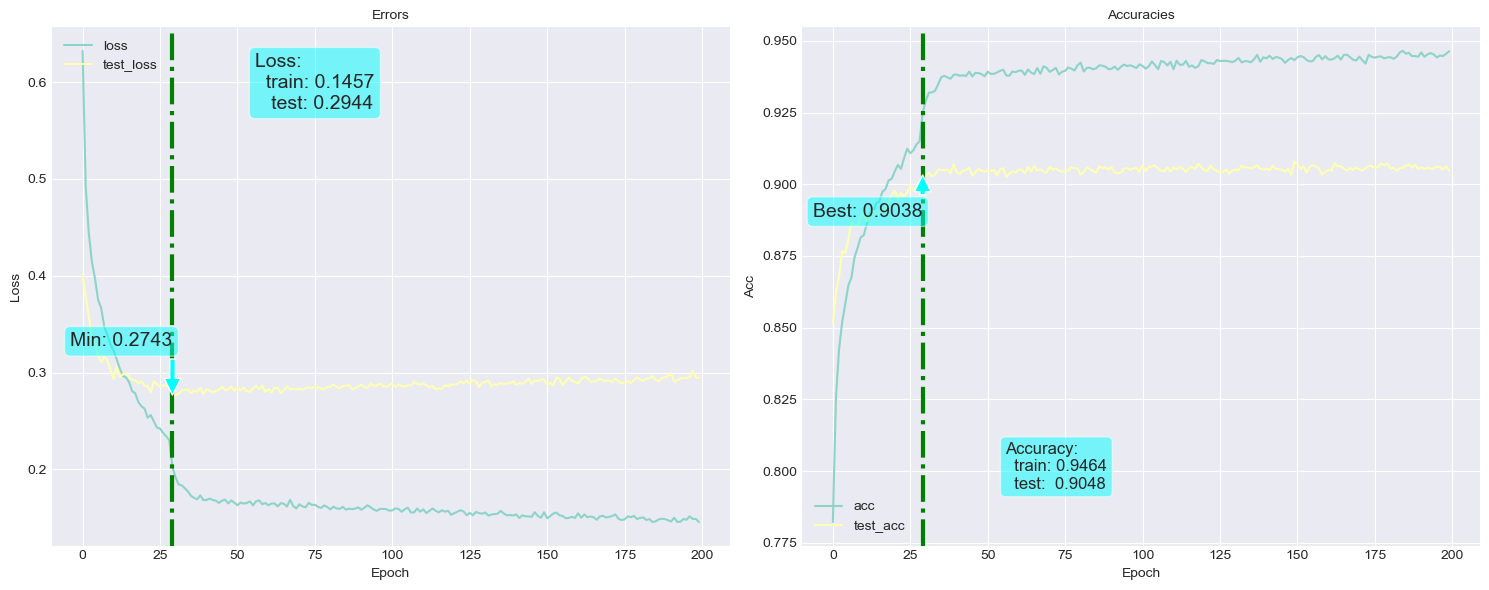

<Figure size 1000x800 with 0 Axes>

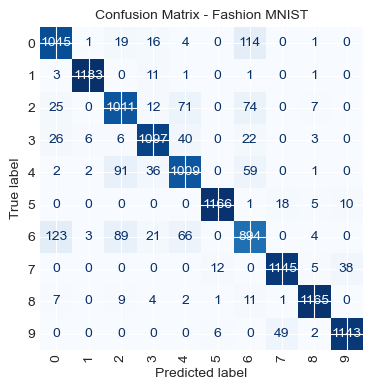

In [80]:

# Prepare DataLoaders with best params
train_dataset = MnistDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=best_params['batch_size'], shuffle=True)
test_dataset = MnistDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize model with best hyperparameters
model = ImprovedModel(
    X_train.shape[1], 
    best_params['hidden_layers'], 
    best_params['dropout_rates']
).to(device)

# Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-5)

# Tracking variables
loss, tloss, n_epoch, acc, tacc = [], [], [], [], []

for epoch in range(200):
    # Training phase
    model.train()
    epoch_loss, epoch_acc = 0, 0
    for batch_idx, (train_X, train_y) in enumerate(train_loader):
        train_X, train_y = train_X.to(device), train_y.to(device)
        
        # Forward pass
        predict_proba = model(train_X)
        batch_loss = loss_fn(predict_proba, train_y)
        
        # Backward pass
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        # Compute training metrics
        epoch_loss += batch_loss.item()
        y_pred = predict_proba.argmax(dim=1)
        epoch_acc += (y_pred == train_y).float().mean().item()
    
    # Normalize epoch metrics
    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    loss.append(epoch_loss)
    acc.append(epoch_acc)
    
    # Validation phase
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            batch_loss = loss_fn(outputs, batch_y)
            
            test_loss += batch_loss.item()
            test_acc += (outputs.argmax(1) == batch_y).float().mean().item()
    
    # Normalize test metrics
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    tloss.append(test_loss)
    tacc.append(test_acc)
    n_epoch.append(epoch)
    
    # Step the scheduler
    scheduler.step(test_loss)
    
    # Print progress
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {epoch_loss:.5f}/{test_loss:.5f} | Accuracy: {epoch_acc:.5f}/{test_acc:.5f}')

# Create DataFrame for plotting
loss_df = pd.DataFrame({
    'epoch': n_epoch, 
    'loss': loss, 
    'test_loss': tloss, 
    'acc': acc, 
    'test_acc': tacc
})

# Call the plotting function
fn_plot_torch_hist(hist_df=loss_df)

# Evaluation
model.eval()
y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        y_pred.extend(outputs.argmax(1).cpu().numpy())

# Compute full metrics
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)
plt.title("Confusion Matrix - Fashion MNIST")
plt.tight_layout()
plt.show()
